### Import dataset

In [ ]:
!pip install --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
2.18.0
3.5.0


In [ ]:
import gdown

file_id = 'https://drive.google.com/file/d/15I6N4OWpP4JVX_jTEEtQQUKf4QxEIVbR/view?usp=sharing'

output_path = 'image_detection.v3i.tensorflow.zip'

gdown.download(url=file_id, output=output_path, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=15I6N4OWpP4JVX_jTEEtQQUKf4QxEIVbR
From (redirected): https://drive.google.com/uc?id=15I6N4OWpP4JVX_jTEEtQQUKf4QxEIVbR&confirm=t&uuid=d299934a-fb58-4b17-9a04-3248d578454f
To: /content/image_detection.v3i.tensorflow.zip
100%|██████████| 434M/434M [00:05<00:00, 84.6MB/s]


'image_detection.v3i.tensorflow.zip'

In [ ]:
!unzip /content/image_detection.v3i.tensorflow.zip

Archive:  /content/image_detection.v3i.tensorflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/food.tfrecord      
  inflating: test/food_label_map.pbtxt  
   creating: train/
 extracting: train/food.tfrecord     
  inflating: train/food_label_map.pbtxt  
   creating: valid/
 extracting: valid/food.tfrecord     
  inflating: valid/food_label_map.pbtxt  


### Preprocess Image

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
train_dataset = tf.data.TFRecordDataset("/content/train/food.tfrecord")
test_dataset = tf.data.TFRecordDataset("/content/test/food.tfrecord")
valid_dataset = tf.data.TFRecordDataset("/content/valid/food.tfrecord")

for raw_record in train_dataset.take(4):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list {
      }
    }
  }
  feature {
    key: "image/object/bbox/xmin"
    value {
      float_list {
      }
    }
  }
  feature {
    key: "image/object/bbox/xmax"
    value {
      float_list {
      }
    }
  }
  feature {
    key: "image/height"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "jpeg"
      }
    }
  }
  feature {
    key: "image/filename"
    value {
      bytes_list {
        value: "bebek_betutu_253_

In [ ]:
# Load the label map and create a dictionary mapping class IDs to names
def load_label_map(label_map_path):
    temp = {}
    class_id = None  # Initialize class_id to None
    with open(label_map_path, 'r') as f:
        for line in f:
            if 'id:' in line:
                class_id = int(line.split('id:')[1].strip().rstrip(','))
            if 'display_name:' in line and class_id is not None:  # Check if class_id is assigned
                class_name = line.split('display_name:')[1].strip().replace("'", "").replace('"', "").replace(",", "")  # Remove quotes
                temp[class_id] = class_name
    return temp

class_mapping = load_label_map("/content/train/food_label_map.pbtxt")
class_mapping

{1: 'Ayam',
 2: 'Bakso',
 3: 'Cumi',
 4: 'Gado Gado',
 5: 'Gudeg',
 6: 'Ikan',
 7: 'Nasi',
 8: 'Pempek',
 9: 'Sate',
 10: 'Soto'}

In [ ]:
import tensorflow as tf


def parse_tfrecord_fn(example, max_boxes=2, num_classes=35):
    # Define the feature description dictionary
    feature_description = {
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    }

    # Parse the input `tf.train.Example`
    parsed_features = tf.io.parse_single_example(example, feature_description)

    # Decode the image
    image = tf.io.decode_jpeg(parsed_features['image/encoded'])
    image = tf.image.resize(image, [224, 224])

    # Convert sparse tensors to dense tensors for bounding boxes
    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'], default_value=0.0)
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'], default_value=0.0)
    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'], default_value=0.0)
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'], default_value=0.0)

    # Combine all bounding boxes into one tensor of shape (num_boxes, 4)
    bboxes = tf.stack([ymin, xmin, ymax, xmax], axis=-1)  # [num_boxes, 4]

    # Truncate bounding boxes if necessary to keep only the first max_boxes
    bboxes = bboxes[:max_boxes]

    # # Pad bounding boxes if necessary
    # bboxes = tf.pad(bboxes, [[0, max_boxes - tf.shape(bboxes)[0]], [0, 0]], constant_values=0.0)

    # Get class labels (convert sparse tensor to dense)
    labels = tf.sparse.to_dense(parsed_features['image/object/class/label'], default_value=0)

    # Slice labels to keep only the first max_boxes
    labels = labels[:max_boxes]

    # Pad labels to match the max number of boxes
    # labels = tf.pad(labels, [[0, max_boxes - tf.shape(labels)[0]]], constant_values=0)

    # One-hot encode class labels
    one_hot_labels = tf.one_hot(labels, num_classes)

    # Pad bounding boxes and labels if necessary to ensure max_boxes shape
    bboxes = tf.pad(bboxes, [[0, max_boxes - tf.shape(bboxes)[0]], [0, 0]], constant_values=0.0)
    one_hot_labels = tf.pad(one_hot_labels, [[0, max_boxes - tf.shape(one_hot_labels)[0]], [0, 0]], constant_values=0.0)

    return image, (bboxes, one_hot_labels)


# Create a dataset from the TFRecord file
train_dataset = tf.data.TFRecordDataset("/content/train/food.tfrecord")
test_dataset = tf.data.TFRecordDataset("/content/test/food.tfrecord")
valid_dataset = tf.data.TFRecordDataset("/content/valid/food.tfrecord")

# Map the parse function to the dataset
train_dataset = train_dataset.map(parse_tfrecord_fn)
test_dataset = test_dataset.map(parse_tfrecord_fn)
valid_dataset = valid_dataset.map(parse_tfrecord_fn)

# Optional: Perform batching and data augmentation (e.g., resizing)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

# Iterate through the dataset and access the image and associated features
# for image, features, labels_text in train_dataset:
#     print(features)  # Dictionary of parsed features
#     # Further processing (e.g., bounding box, labels, etc.)

In [ ]:
for image, (bboxes, labels) in train_dataset.take(5):  # Inspect 5 samples
    print("Image shape:", image.shape)
    print("Bounding box shape:", bboxes.shape)
    print("Class labels shape:", labels.shape)

Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)


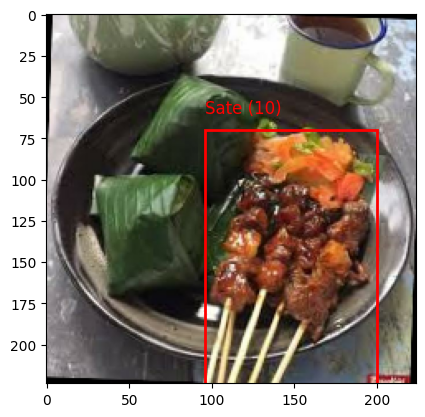

In [ ]:
import random


def display_random_image_with_bbox(dataset):
    """Displays a random image from the dataset with its bounding box."""
    image_data = list(dataset.as_numpy_iterator())  # Convert the dataset to a list for random access
    random_index = random.randint(0, len(image_data) - 1)
    image, (bboxes, labels) = image_data[random_index]

    # Assuming the first image in the batch is what we want (batch size = 1)
    image = image[0]
    bboxes = bboxes[0]
    labels = labels[0]

    # Find the first non-zero bounding box (object present)
    for i in range(bboxes.shape[0]):
      if np.any(bboxes[i] != 0):
        ymin, xmin, ymax, xmax = bboxes[i]
        # Convert normalized coordinates to pixel coordinates
        height, width, _ = image.shape
        x1 = int(xmin * width)
        y1 = int(ymin * height)
        x2 = int(xmax * width)
        y2 = int(ymax * height)

        class_id = np.argmax(labels[i]) # Get class ID from one-hot encoded labels
        class_name = class_mapping.get(class_id, "Unknown") # +1 because class_mapping starts from 1

        plt.imshow(image.astype(np.uint8))  # added .astype(np.uint8) for displaying
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1})", color='red', fontsize=12)
        plt.show()
        break
    else:
      print("No objects found in the selected image")

# Call the function
display_random_image_with_bbox(train_dataset)

### Augmentation (Pending)

In [ ]:
# def random_flip(image, bboxes):
#     """Randomly flip the image horizontally and adjust bounding boxes."""
#     if tf.random.uniform(()) > 0.5:
#         image = tf.image.flip_left_right(image)
#         # Flip bounding boxes by swapping xmin and xmax
#         bboxes = tf.stack([bboxes[:, 0], 1 - bboxes[:, 3], bboxes[:, 2], 1 - bboxes[:, 1]], axis=1)
#     return image, bboxes


# def random_brightness(image):
#     """Randomly adjust brightness of the image."""
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     return image

# def random_rotation(image, bboxes):
#     """Randomly rotate the image by 90 degrees and adjust bounding boxes."""
#     k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
#     image = tf.image.rot90(image, k)
#     if k == 1:
#         # 90 degrees
#         bboxes = tf.stack([bboxes[:,1], 1 - bboxes[:,2], bboxes[:,3], 1 - bboxes[:,0]], axis=1)
#     elif k == 2:
#         # 180 degrees
#         bboxes = tf.stack([1 - bboxes[:,2], 1 - bboxes[:,3], 1 - bboxes[:,0], 1 - bboxes[:,1]], axis=1)
#     elif k == 3:
#         # 270 degrees
#         bboxes = tf.stack([1 - bboxes[:,3], bboxes[:,0], 1 - bboxes[:,1], bboxes[:,2]], axis=1)
#     return image, bboxes

# def normalize_image(image):
#     """Normalize image to [0,1]."""
#     image = tf.cast(image, tf.float32) / 255.0
#     return image

# def augment(image, bboxes, labels):
#     """Apply data augmentation to image and adjust bounding boxes."""
#     # tf.debugging.assert_shapes([(image, [None, None, 3]), (bboxes, [None, 4]), (labels, [None, 35])])
#     image, bboxes = random_flip(image, bboxes)
#     image = random_brightness(image)
#     image, bboxes = random_rotation(image, bboxes)
#     image = normalize_image(image)

#     # Check if bounding box values are still within valid range
#     bboxes = tf.clip_by_value(bboxes, 0.0, 1.0)

#     # Ensure the bounding boxes are not empty
#     non_empty_bboxes = tf.reduce_any(bboxes != 0, axis=1)

#     # Reshape the non_empty_bboxes tensor to match the image dimensions
#     # non_empty_bboxes = tf.reshape(non_empty_bboxes, [-1, 1, 1, 1]) # Reshape to (batch_size, 1, 1, 1)
#     # non_empty_bboxes = tf.tile(non_empty_bboxes, [1, tf.shape(image)[1], tf.shape(image)[2], tf.shape(image)[3]])

#     # Ensure the bounding boxes are not empty
#     # non_empty_bboxes = tf.reduce_any(bboxes != 0, axis=1)
#     # image = tf.boolean_mask(image, non_empty_bboxes)
#     # bboxes = tf.boolean_mask(bboxes, non_empty_bboxes)
#     # labels = tf.boolean_mask(labels, non_empty_bboxes)

#     return image, (bboxes, labels)

# # Assuming your train_dataset yields (image, (bboxes, labels))
# augmented_train_dataset = train_dataset.map(
#     lambda img, targets: augment(img, targets[0], targets[1]),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# # Prefetch for performance
# augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)


### Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_object_detection_model(input_shape=(224, 224, 3), num_classes=35, max_boxes=2):

    # Input layer
    inputs = Input(shape=input_shape)

    # Pre-trained ResNet50 as feature extractor
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False  # Freeze ResNet50 layers

    # Unfreeze the last few layers of ResNet50
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Global Average Pooling
    x = GlobalAveragePooling2D()(base_model.output)

    # First Dense Layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second Dense Layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    # Output for Bounding Boxes
    bbox_output = Dense(max_boxes * 4, activation='linear', name='bbox_output')(x)
    bbox_output_reshape = Reshape((max_boxes, 4), name='bbox_output_reshape')(bbox_output)

    # Output for Classification
    class_output = Dense(max_boxes * num_classes, activation='softmax', name='class_output')(x)
    class_output_reshape = Reshape((max_boxes, num_classes), name='class_output_reshape')(class_output)

    # Define the model with two outputs
    model = Model(inputs=inputs, outputs=[bbox_output_reshape, class_output_reshape])

    optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)

    # Compile the model with appropriate loss functions and optimizer
    model.compile(
        optimizer=optimizer,  # Consider using a lower learning rate if issues persist
        loss={
            'bbox_output_reshape': tf.keras.losses.MeanSquaredError(),  # or 'smooth_l1'
            'class_output_reshape': tf.keras.losses.CategoricalCrossentropy()
        },
        metrics={
            'bbox_output_reshape': tf.keras.losses.MeanAbsoluteError(),  # Mean Absolute Error
            'class_output_reshape': tf.keras.metrics.CategoricalAccuracy()
        }
    )

    return model


# Create the model
model = create_object_detection_model()

# Check the model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,791,246 (94.57 MB)

 Trainable params: 5,667,662 (21.62 MB)

 Non-trainable params: 19,123,584 (72.95 MB)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset
)

Epoch 1/20
    466/Unknown 58s 77ms/step - bbox_output_reshape_loss: 1.8923 - bbox_output_reshape_mean_absolute_error: 1.0109 - class_output_reshape_categorical_accuracy: 0.1201 - class_output_reshape_loss: 0.6473 - loss: 2.5396

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


466/466 ━━━━━━━━━━━━━━━━━━━━ 71s 105ms/step - bbox_output_reshape_loss: 1.8905 - bbox_output_reshape_mean_absolute_error: 1.0103 - class_output_reshape_categorical_accuracy: 0.1202 - class_output_reshape_loss: 0.6468 - loss: 2.5373 - val_bbox_output_reshape_loss: 0.0598 - val_bbox_output_reshape_mean_absolute_error: 0.1688 - val_class_output_reshape_categorical_accuracy: 0.2488 - val_class_output_reshape_loss: 0.1912 - val_loss: 0.2527
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - bbox_output_reshape_loss: 0.1220 - bbox_output_reshape_mean_absolute_error: 0.2456 - class_output_reshape_categorical_accuracy: 0.2197 - class_output_reshape_loss: 0.1714 - loss: 0.2934 - val_bbox_output_reshape_loss: 0.0453 - val_bbox_output_reshape_mean_absolute_error: 0.1442 - val_class_output_reshape_categorical_accuracy: 0.2715 - val_class_output_reshape_loss: 0.1193 - val_loss: 0.1649
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - bbox_output_reshape_loss: 0.0463 - bbox_output_reshape

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_class_loss, test_bbox_loss, test_class_acc, test_bbox_acc = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Classification Loss: {test_class_loss}")
print(f"Test BBox Loss: {test_bbox_loss}")
print(f"Test Classification Accuracy: {test_class_acc}")
print(f"Test BBox Accuracy: {test_bbox_acc}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - bbox_output_reshape_loss: 0.0320 - bbox_output_reshape_mean_absolute_error: 0.1093 - class_output_reshape_categorical_accuracy: 0.2701 - class_output_reshape_loss: 0.1487 - loss: 0.1810
Test Loss: 0.1450037807226181
Test Classification Loss: 0.03206253796815872
Test BBox Loss: 0.11004626005887985
Test Classification Accuracy: 0.110558420419693
Test BBox Accuracy: 0.2925170063972473


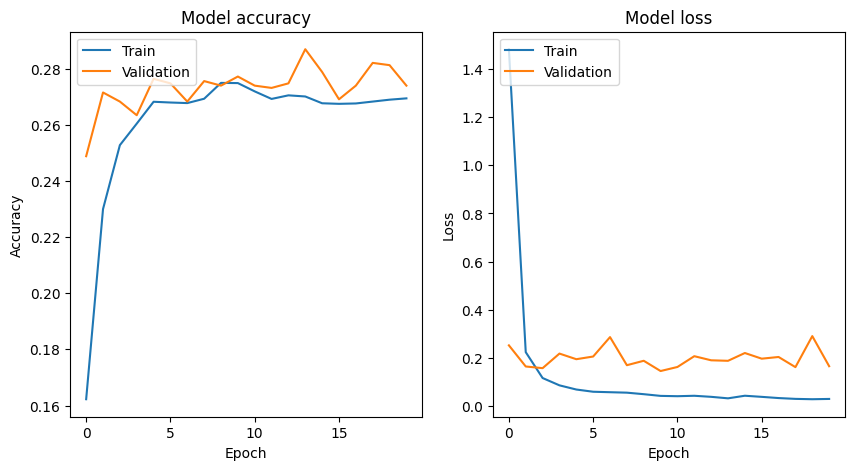

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_reshape_categorical_accuracy'])
plt.plot(history.history['val_class_output_reshape_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


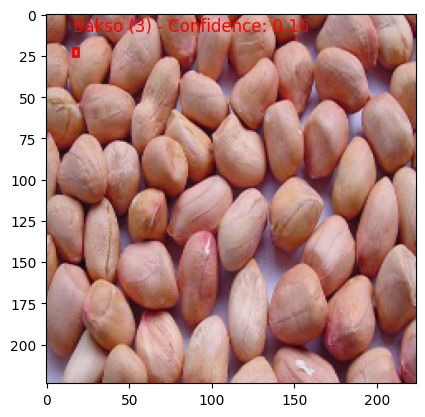

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def predict_and_display_image(dataset, model, confidence_threshold=0):
    """Predicts and displays a random image from the dataset with bounding boxes,
       ensuring confidence is above the threshold.
    """
    image_data = list(dataset.as_numpy_iterator())
    while True:  # Keep trying until a suitable image is found
        random_index = random.randint(0, len(image_data) - 1)
        image, (bboxes, labels) = image_data[random_index]
        image = image[0]  # Get the first image in the batch
        bboxes = bboxes[0]
        labels = labels[0]

        predicted_bboxes, predicted_labels = model.predict(np.expand_dims(image, axis=0))
        predicted_bboxes = predicted_bboxes[0]
        predicted_labels = predicted_labels[0]

        # Find an object with confidence above the threshold
        for i in range(predicted_bboxes.shape[0]):
          if np.any(predicted_bboxes[i]!=0):
            class_id = np.argmax(predicted_labels[i])
            confidence = np.max(predicted_labels[i]) # Assuming softmax output for confidence

            if confidence >= confidence_threshold:
                ymin, xmin, ymax, xmax = predicted_bboxes[i]
                height, width, _ = image.shape
                x1 = int(xmin * width)
                y1 = int(ymin * height)
                x2 = int(xmax * width)
                y2 = int(ymax * height)

                class_name = class_mapping.get(class_id, "Unknown")

                plt.imshow(image.astype(np.uint8))
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1}) - Confidence: {confidence:.2f}", color='red', fontsize=12)
                plt.show()
                return # Exit the function after displaying a valid prediction

        print("No object found with sufficient confidence. Trying a different image...")
# Call the function
predict_and_display_image(test_dataset, model)

In [ ]:
model.save('food_bbox.keras')

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


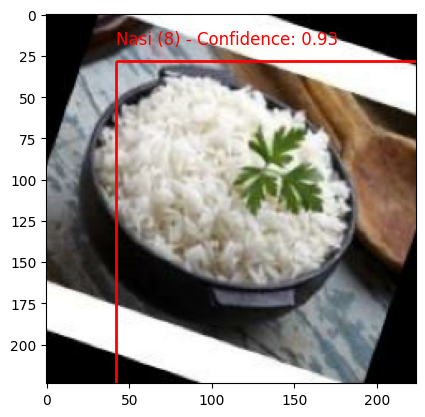

In [ ]:
# Load the model
from tensorflow import keras
loaded_model = keras.models.load_model('food_bbox.keras')

# Now you can use the loaded_model for predictions
def predict_and_display_image(dataset, model, confidence_threshold=0.75):
    """Predicts and displays a random image from the dataset with bounding boxes,
       ensuring confidence is above the threshold.
    """
    image_data = list(dataset.as_numpy_iterator())
    while True:  # Keep trying until a suitable image is found
        random_index = random.randint(0, len(image_data) - 1)
        image, (bboxes, labels) = image_data[random_index]
        image = image[0]  # Get the first image in the batch
        bboxes = bboxes[0]
        labels = labels[0]

        predicted_bboxes, predicted_labels = model.predict(np.expand_dims(image, axis=0))
        predicted_bboxes = predicted_bboxes[0]
        predicted_labels = predicted_labels[0]

        # Find an object with confidence above the threshold
        for i in range(predicted_bboxes.shape[0]):
          if np.any(predicted_bboxes[i]!=0):
            class_id = np.argmax(predicted_labels[i])
            confidence = np.max(predicted_labels[i]) # Assuming softmax output for confidence

            if confidence >= confidence_threshold:
                ymin, xmin, ymax, xmax = predicted_bboxes[i]
                height, width, _ = image.shape
                x1 = int(xmin * width)
                y1 = int(ymin * height)
                x2 = int(xmax * width)
                y2 = int(ymax * height)

                class_name = class_mapping.get(class_id, "Unknown")

                plt.imshow(image.astype(np.uint8))
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1}) - Confidence: {confidence:.2f}", color='red', fontsize=12)
                plt.show()
                return # Exit the function after displaying a valid prediction

        print("No object found with sufficient confidence. Trying a different image...")
# Call the function with the loaded model
predict_and_display_image(test_dataset, loaded_model)